In [15]:
import numpy as np
import pandas as pd
import os
os.chdir(r"C:\Users\Mohiuddin\Desktop\machine learning\ML\Kaggle-Carrercon")
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from functools import reduce
import random
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
data = pd.read_csv('X_train.csv')
target = pd.read_csv('y_train.csv')
test = pd.read_csv('X_test.csv')
submission = pd.read_csv('sample_submission.csv')


In [121]:
print(data.shape)
data.head()

(487680, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [3]:
data = data[['series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z']]

In [4]:
testing = test.groupby("series_id").mean().reset_index()
testing.shape

(3816, 12)

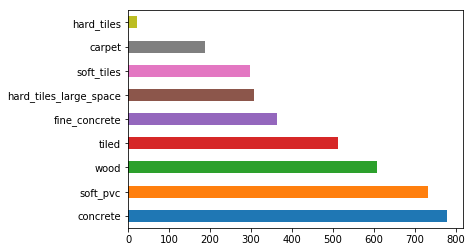

In [5]:
pd.value_counts(target['surface']).plot(kind='barh');

In [6]:
data.isnull().sum()

series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [7]:
def feat_eng(data):
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z'])** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
    #Lets derive one more column since there is a relationship in velocity and acceleration
    # v = u + a*t , u is initial velocty. if u = 0, then v = at means t = v/a
    # but value of acceleration is more and value of velocity is less, lets do a/v relation
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    # Deriving more feature, since we are reducing rows now, we should know min,max,mean values
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [118]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [9]:
data = feat_eng(data)
test = feat_eng(test)

In [10]:
# Filling missing data by zeroes
data.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.fillna(0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [109]:
data.head()

""


In [21]:
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [11]:
target['surface']=target.surface.map({"fine_concrete":0,"concrete":1,'soft_tiles':2,'tiled':3,'soft_pvc':4,'hard_tiles_large_space':5
                                   ,'carpet':6,'hard_tiles':7,'wood':8})

In [12]:
targs = target['surface']
#df.drop(['surface'], axis=1, inplace=True)

In [17]:
#df.drop(['series_id','group_id'], axis=1, inplace=True)
#testing.drop(['series_id'], axis=1, inplace=True)

In [13]:
print(data.shape)
print(test.shape)
print(targs.shape)

(3810, 126)
(3816, 126)
(3810,)


In [ ]:
#-----test-----

In [16]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(data))
X_test_scaled = pd.DataFrame(scaler.transform(test))
print ("Scaled !")

Scaled !


In [20]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

In [21]:
data = X_train_scaled
test = X_test_scaled

In [22]:
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0

In [23]:
# https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment#500381
# thanks to @vishalsrinirao
def shuffle_col_vals(x1):
    rand_x = np.array([np.random.choice(x1.shape[0], size=x1.shape[0], replace=False) for i in range(x1.shape[1])]).T
    grid = np.indices(x1.shape)
    rand_y = grid[1]
    return x1[(rand_x, rand_y)]

def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        x1 = shuffle_col_vals(x1)
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        x1 = shuffle_col_vals(x1)
        xn.append(x1)

    xs = np.vstack(xs); xn = np.vstack(xn)
    ys = np.ones(xs.shape[0]);yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn]); y = np.concatenate([y,ys,yn])
    return x,y

for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    
    model = RandomForestClassifier(n_estimators=120, bootstrap=True, class_weight="balanced", random_state=2019)
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = data.columns
    
    if model.score(data.iloc[val_idx],target['surface'][val_idx]) > 0.9500:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

Fold: 0 score: 0.9168831168831169
Fold: 1 score: 0.8723958333333334
Fold: 2 score: 0.8798955613577023
Fold: 3 score: 0.8926701570680629
Fold: 4 score: 0.9002624671916011
Fold: 5 score: 0.8792650918635171
Fold: 6 score: 0.8556430446194225
Fold: 7 score: 0.8812664907651715
Fold: 8 score: 0.8835978835978836
Fold: 9 score: 0.9228723404255319


In [25]:
print('Avg Accuracy RF', score / folds.n_splits)

Avg Accuracy RF 0.8884751987105343


In [26]:
confusion_matrix(measured,target['surface'])

array([[295,   9,   1,   4,   4,   2,   0,   0,   6],
       [ 18, 682,   4,  21,  21,  14,  13,   0,  13],
       [  2,   7, 281,   3,   6,   1,   3,   2,   3],
       [ 12,  12,   0, 464,   2,   0,   1,   0,  19],
       [ 11,  24,   5,   9, 678,   2,   2,   1,  32],
       [  1,  15,   0,   2,   3, 278,   0,   0,   1],
       [  0,   3,   1,   3,   3,   2, 159,   0,   1],
       [  0,   0,   1,   0,   0,   0,   0,  17,   1],
       [ 24,  27,   4,   8,  15,   9,  11,   1, 531]], dtype=int64)

In [28]:
test_sub = model.predict(test)

In [34]:
Pred = pd.DataFrame({"surface":test_sub})

In [35]:
submission['surface']=Pred.surface.map({0:"fine_concrete",1:"concrete",2:'soft_tiles',3:'tiled',4:'soft_pvc',5:'hard_tiles_large_space'
                                   ,6:'carpet',7:'hard_tiles',8:'wood'})

In [36]:
submission.to_csv('submissionNew.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [ ]:
#-----test-----

In [37]:
#----test2---

In [42]:
clf = RandomForestClassifier(n_estimators = 2000,
                               max_depth=20, 
                             min_samples_split=5,
                             class_weight='balanced')
                            
clf.fit(data, targs)
ress  = clf.predict(test)

In [43]:
Pred = pd.DataFrame({"surface":ress})
submission['surface']=Pred.surface.map({0:"fine_concrete",1:"concrete",2:'soft_tiles',3:'tiled',4:'soft_pvc',5:'hard_tiles_large_space'
                                   ,6:'carpet',7:'hard_tiles',8:'wood'})
submission.to_csv('submissionNewRFF.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles


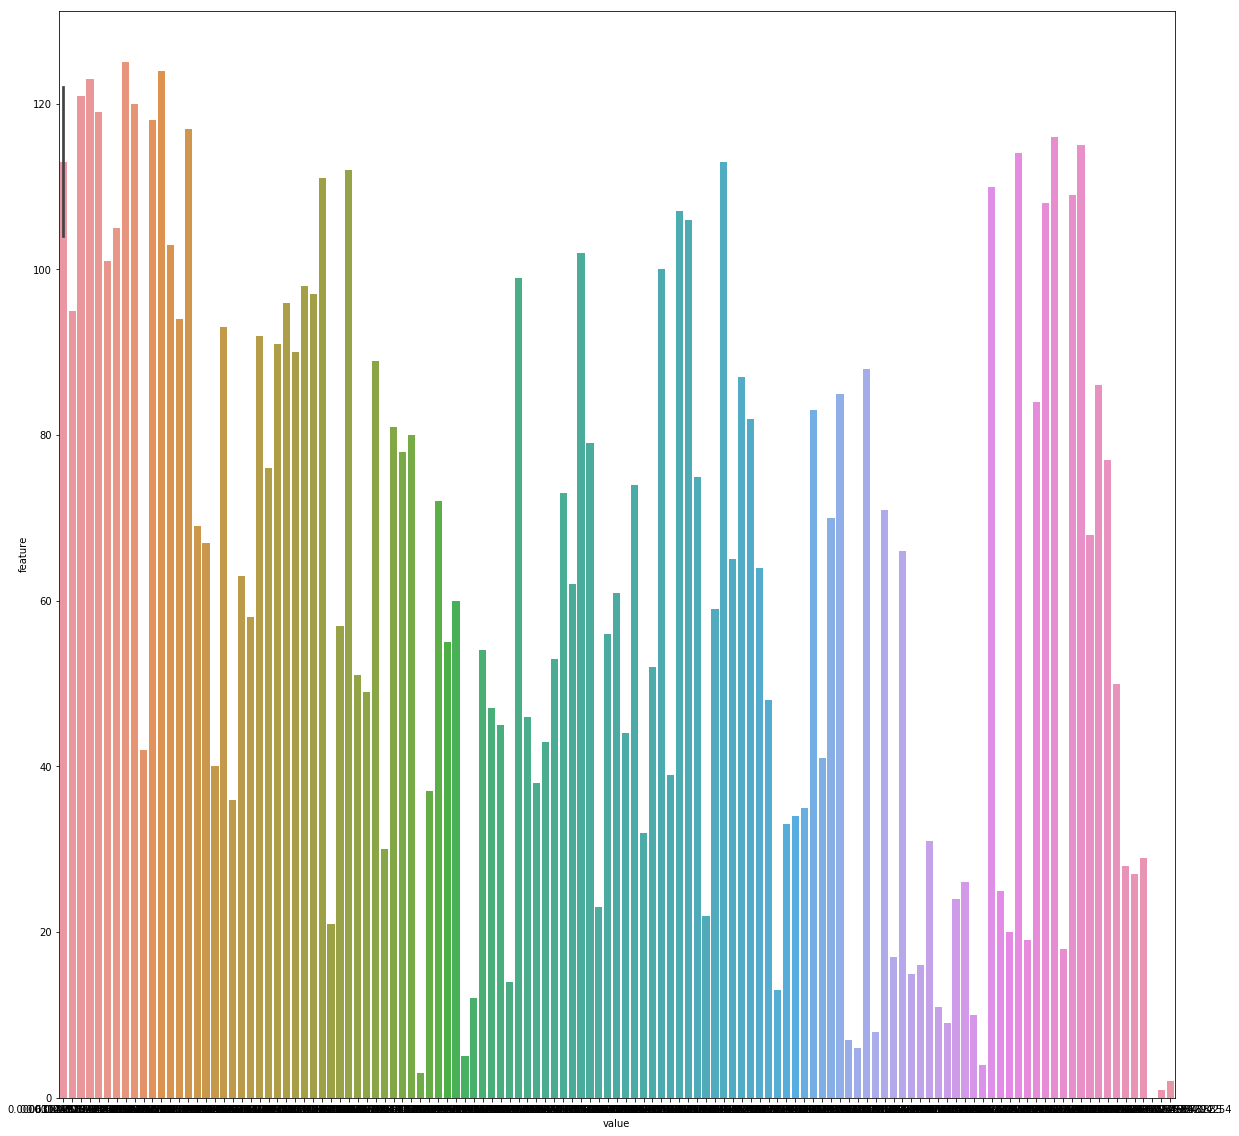

In [45]:
importance = pd.DataFrame({'value': clf.feature_importances_,
                           'feature': np.array(data.columns)})
importance.sort_values(by='value', ascending=False, inplace=True)
plt.figure(figsize=(20, 20))
sns.barplot(x='value', y='feature', data=importance);

In [47]:
#----test2--

In [52]:
X_train = data
X_test = test
y_train = target

In [53]:
USE_LGB = False
if(USE_LGB):
    sub_preds_lgb = np.zeros((X_test.shape[0], 9))
    oof_preds_lgb = np.zeros((X_train.shape[0]))
    score = 0
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train['surface'])):
        train_x, train_y = X_train.iloc[trn_idx], y_train['surface'][trn_idx]
        valid_x, valid_y = X_train.iloc[val_idx], y_train['surface'][val_idx]
        clf =  LGBMClassifier(
                      nthread=-1,
                      n_estimators=2000,
                      learning_rate=0.01,
                      boosting_type='gbdt',
                      is_unbalance=True,
                      objective='multiclass',
                      numclass=9,
                      silent=-1,
                      verbose=-1,
                      feval=None)
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                     verbose= 1000, early_stopping_rounds= 200)

        oof_preds_lgb[val_idx] = clf.predict(valid_x)
        sub_preds_lgb += clf.predict_proba(X_test) / folds.n_splits
        score += clf.score(valid_x, valid_y)
        print('Fold: {} score: {}'.format(fold_,clf.score(valid_x, valid_y)))
    print('Avg Accuracy', score / folds.n_splits)

In [60]:
USE_LGB = False
if(USE_LGB):
    Pred = sub_preds_lgb.argmax(axis=1)

In [63]:
submission['surface']=Pred.surface.map({0:"fine_concrete",1:"concrete",2:'soft_tiles',3:'tiled',4:'soft_pvc',5:'hard_tiles_large_space'
                                   ,6:'carpet',7:'hard_tiles',8:'wood'})
submission.to_csv('submissionNewlgb.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [26]:
test.head()

,orientation_X_mean,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_min,orientation_X_abs_max,orientation_X_abs_avg,orientation_Y_mean,...,totl_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_min,acc_vs_vel_abs_max,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.025810,-0.025156,-0.026418,0.000284,0.952230,0.000055,0.025156,0.026418,0.025787,-0.988644,...,0.911022,19.131971,92.643199,2.912813,16.938512,31.805410,0.0,2.912813,92.643199,47.778006
1,-0.932288,-0.931480,-0.933720,0.000564,0.997601,0.000021,0.931480,0.933720,0.932600,0.330271,...,1.010664,63.413731,608.967417,4.624328,146.865200,131.687777,0.0,4.624328,608.967417,306.795872
2,-0.230186,-0.227130,-0.231410,0.001054,0.981505,0.000093,0.227130,0.231410,0.229270,0.961448,...,1.059105,19.134922,76.868998,2.666308,15.878651,28.829751,0.0,2.666308,76.868998,39.767653
3,0.164661,0.167500,0.163320,0.001182,1.025594,0.000037,0.163320,0.167500,0.165410,0.975293,...,1.060406,7.808499,21.776972,1.487060,4.333372,14.644310,0.0,1.487060,21.776972,11.632016
4,-0.253600,-0.236370,-0.269380,0.009763,0.877459,0.000260,0.236370,0.269380,0.252875,0.955712,...,1.058280,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [27]:
targs.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import gc
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

In [103]:
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,targs.values)):
    model = RandomForestClassifier(n_estimators=500)
    model.fit(data.iloc[trn_idx],targs[trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],targs[val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],targs[val_idx])))
    gc.collect()
print('Avg Accuracy', score / folds.n_splits)

ValueError: Found input variables with inconsistent numbers of samples: [0, 3810]

In [91]:
Pred= predicted.argmax(axis=1)
Pred = pd.DataFrame({"surface":Pred})

In [51]:
Pred.head()

,surface
0,5
1,6
2,3
3,6
4,2


In [92]:
submission['surface']=Pred.surface.map({0:"fine_concrete",1:"concrete",2:'soft_tiles',3:'tiled',4:'soft_pvc',5:'hard_tiles_large_space'
                                   ,6:'carpet',7:'hard_tiles',8:'wood'})

In [93]:
submission.to_csv('submission14.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [56]:
# Create 0.75/0.25 train/test split
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(data, targs, test_size=0.25, train_size=0.75,
                                                    random_state=42)

In [57]:
# Leave most parameters as default
param = {'objective': 'multi:softmax', # Specify multiclass classification
         'num_class': 9, # Number of possible output classes
         'tree_method': 'hist' # Use gpu_hist for GPU accelerated algorithm.
         }

In [58]:
# Convert input data from numpy to XGBoost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [59]:
dtext_X = xgb.DMatrix(test)

In [67]:
num_round = 1500
gpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
bst=xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
print("CPU Training Time: %s seconds" % (str(time.time() - tmp))) #tried to time it aganst GPU 

[0]	test-merror:0.282267
[1]	test-merror:0.237146
[2]	test-merror:0.217209
[3]	test-merror:0.205666
[4]	test-merror:0.208814
[5]	test-merror:0.193074
[6]	test-merror:0.181532
[7]	test-merror:0.171039
[8]	test-merror:0.162644
[9]	test-merror:0.155299
[10]	test-merror:0.147954
[11]	test-merror:0.141658
[12]	test-merror:0.13851
[13]	test-merror:0.135362
[14]	test-merror:0.141658
[15]	test-merror:0.140609
[16]	test-merror:0.136411
[17]	test-merror:0.137461
[18]	test-merror:0.132214
[19]	test-merror:0.132214
[20]	test-merror:0.134313
[21]	test-merror:0.131165
[22]	test-merror:0.133263
[23]	test-merror:0.129066
[24]	test-merror:0.130115
[25]	test-merror:0.131165
[26]	test-merror:0.12277
[27]	test-merror:0.119622
[28]	test-merror:0.121721
[29]	test-merror:0.120672
[30]	test-merror:0.12382
[31]	test-merror:0.120672
[32]	test-merror:0.117524
[33]	test-merror:0.119622
[34]	test-merror:0.118573
[35]	test-merror:0.119622
[36]	test-merror:0.119622
[37]	test-merror:0.118573
[38]	test-merror:0.116474

[310]	test-merror:0.103882
[311]	test-merror:0.104932
[312]	test-merror:0.104932
[313]	test-merror:0.104932
[314]	test-merror:0.104932
[315]	test-merror:0.104932
[316]	test-merror:0.103882
[317]	test-merror:0.103882
[318]	test-merror:0.103882
[319]	test-merror:0.103882
[320]	test-merror:0.102833
[321]	test-merror:0.102833
[322]	test-merror:0.102833
[323]	test-merror:0.103882
[324]	test-merror:0.103882
[325]	test-merror:0.102833
[326]	test-merror:0.102833
[327]	test-merror:0.102833
[328]	test-merror:0.102833
[329]	test-merror:0.102833
[330]	test-merror:0.102833
[331]	test-merror:0.102833
[332]	test-merror:0.102833
[333]	test-merror:0.102833
[334]	test-merror:0.102833
[335]	test-merror:0.102833
[336]	test-merror:0.102833
[337]	test-merror:0.102833
[338]	test-merror:0.103882
[339]	test-merror:0.103882
[340]	test-merror:0.102833
[341]	test-merror:0.102833
[342]	test-merror:0.102833
[343]	test-merror:0.102833
[344]	test-merror:0.102833
[345]	test-merror:0.102833
[346]	test-merror:0.103882
[

[617]	test-merror:0.109129
[618]	test-merror:0.109129
[619]	test-merror:0.109129
[620]	test-merror:0.109129
[621]	test-merror:0.109129
[622]	test-merror:0.109129
[623]	test-merror:0.109129
[624]	test-merror:0.109129
[625]	test-merror:0.109129
[626]	test-merror:0.109129
[627]	test-merror:0.109129
[628]	test-merror:0.109129
[629]	test-merror:0.10808
[630]	test-merror:0.109129
[631]	test-merror:0.109129
[632]	test-merror:0.109129
[633]	test-merror:0.109129
[634]	test-merror:0.109129
[635]	test-merror:0.109129
[636]	test-merror:0.109129
[637]	test-merror:0.109129
[638]	test-merror:0.109129
[639]	test-merror:0.109129
[640]	test-merror:0.109129
[641]	test-merror:0.109129
[642]	test-merror:0.109129
[643]	test-merror:0.109129
[644]	test-merror:0.109129
[645]	test-merror:0.109129
[646]	test-merror:0.109129
[647]	test-merror:0.109129
[648]	test-merror:0.109129
[649]	test-merror:0.109129
[650]	test-merror:0.109129
[651]	test-merror:0.109129
[652]	test-merror:0.109129
[653]	test-merror:0.109129
[6

[927]	test-merror:0.110178
[928]	test-merror:0.110178
[929]	test-merror:0.110178
[930]	test-merror:0.110178
[931]	test-merror:0.110178
[932]	test-merror:0.110178
[933]	test-merror:0.110178
[934]	test-merror:0.110178
[935]	test-merror:0.110178
[936]	test-merror:0.110178
[937]	test-merror:0.110178
[938]	test-merror:0.110178
[939]	test-merror:0.110178
[940]	test-merror:0.110178
[941]	test-merror:0.110178
[942]	test-merror:0.110178
[943]	test-merror:0.110178
[944]	test-merror:0.110178
[945]	test-merror:0.110178
[946]	test-merror:0.110178
[947]	test-merror:0.110178
[948]	test-merror:0.110178
[949]	test-merror:0.110178
[950]	test-merror:0.110178
[951]	test-merror:0.110178
[952]	test-merror:0.110178
[953]	test-merror:0.110178
[954]	test-merror:0.110178
[955]	test-merror:0.110178
[956]	test-merror:0.109129
[957]	test-merror:0.109129
[958]	test-merror:0.109129
[959]	test-merror:0.110178
[960]	test-merror:0.109129
[961]	test-merror:0.109129
[962]	test-merror:0.110178
[963]	test-merror:0.110178
[

[1228]	test-merror:0.10808
[1229]	test-merror:0.10808
[1230]	test-merror:0.10808
[1231]	test-merror:0.10808
[1232]	test-merror:0.10808
[1233]	test-merror:0.10808
[1234]	test-merror:0.10808
[1235]	test-merror:0.10808
[1236]	test-merror:0.10808
[1237]	test-merror:0.10808
[1238]	test-merror:0.10808
[1239]	test-merror:0.10808
[1240]	test-merror:0.10808
[1241]	test-merror:0.10808
[1242]	test-merror:0.10808
[1243]	test-merror:0.10808
[1244]	test-merror:0.10808
[1245]	test-merror:0.10808
[1246]	test-merror:0.10808
[1247]	test-merror:0.10808
[1248]	test-merror:0.10808
[1249]	test-merror:0.10808
[1250]	test-merror:0.10808
[1251]	test-merror:0.10808
[1252]	test-merror:0.10808
[1253]	test-merror:0.10808
[1254]	test-merror:0.10808
[1255]	test-merror:0.10808
[1256]	test-merror:0.10808
[1257]	test-merror:0.10808
[1258]	test-merror:0.10808
[1259]	test-merror:0.10808
[1260]	test-merror:0.10808
[1261]	test-merror:0.10808
[1262]	test-merror:0.10808
[1263]	test-merror:0.10808
[1264]	test-merror:0.10808
[

In [68]:
Pred = bst.predict(dtext_X)
Pred = pd.DataFrame({"surface":Pred})

In [69]:
submission = pd.read_csv('sample_submission.csv')

In [70]:
submission['surface']=Pred.surface.map({0:"fine_concrete",1:"concrete",2:'soft_tiles',3:'tiled',4:'soft_pvc',5:'hard_tiles_large_space'
                                   ,6:'carpet',7:'hard_tiles',8:'wood'})

In [71]:
submission.to_csv('submission13.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,soft_tiles
4,4,soft_pvc
